# Strong Scaling Analysis

## 1. Introduction

This notebook presents a **strong scaling analysis** of our MPI-parallel wave equation solver, implemented with the [deal.II](https://www.dealii.org/) finite element library and Trilinos linear algebra backend.

We solve the 2D wave equation on the unit square $\Omega = [0,1]^2$ with homogeneous Dirichlet boundary conditions and an exact standing-mode solution:

$$u(x,y,t) = \cos(\sqrt{2}\,\pi\,t)\,\sin(\pi x)\,\sin(\pi y)$$

with wave speed $c=1$, zero forcing $f=0$, and initial conditions $u_0 = \sin(\pi x)\sin(\pi y)$, $v_0 = 0$.

### Time integration schemes tested

| Scheme | Parameters | Type |
|:-------|:-----------|:-----|
| **$\theta$-method, $\theta=0$** | Forward Euler (explicit) | Conditionally stable |
| **$\theta$-method, $\theta=0.5$** | Crank–Nicolson (implicit) | Unconditionally stable |
| **$\theta$-method, $\theta=1$** | Backward Euler (implicit) | Unconditionally stable |
| **Newmark, $\beta=0$, $\gamma=0.5$** | Central differences (explicit) | Conditionally stable |
| **Newmark, $\beta=0.25$, $\gamma=0.5$** | Average acceleration (implicit) | Unconditionally stable |

### Problem parameters

| Parameter | Value | why |
|:----------|:------|:----------|
| **Nel** | 640 | Big enough to show the power of parallelization |
| **R** | 1 | - |
| **Δt** | 0.00008 | Small enough to allow explicit methods to not diverge |
| **T** | 0.05 | 625 time steps |

### Linear solver

- **CG** (Conjugate Gradient) with `ReductionControl(10000, 1e-12, 1e-6)`
- **AMG preconditioner** (`TrilinosWrappers::PreconditionAMG`), built **once** on the BC-modified system matrix at the first time step, then reused for all subsequent steps (the system matrix is constant in time)

## 2. Experimental setup

### Hardware

We executed the tests on the "Students Cluster" from the Mathematics department, here the main informations (obtained from `lscpu`):
- **Intel Xeon Gold 6238R**
- 2 sockets/node
- 28 physical cores / socket 
- 2 logical threads / node 
- 2 NUMA nodes
- 38.5 MB L3 cache per socket

### MPI configuration

- **OpenMPI** with `--bind-to core --map-by socket`
- Rank placement: rank 0 → socket 0, rank 1 → socket 1, ...
- `OMP_NUM_THREADS=1` to prevent hyper-threading

### Methodology

1. Each PBS job requests 16 CPUs on a **single node** (max allowed); all process counts (1, 2, 4, 8, 16) run sequentially
2. The code is copied and executed on the `/scratch_local`, which is fast, node-local temporary storage.
3. **3 repeats** per configuration
4. Output I/O and logging are **disabled** (`Save Solution=false`, `Log Every=0`) 
5. We pick the **minimum wall time** (best run) across all the 3 of them, for performing the analisys

### Report of what we did

```bash
# login to the cluster
sudo gpclient connect gp-dmat-saml.vpn.polimi.it
ssh u11177200@10.78.18.100

# setup the repo
qsub -I -q cpu -l select=1:ncpus=16 -l walltime=24:00:00
git clone https://github.com/AlessandroGhiotto/nmpde-wave-equation.git
cd nmpde-wave-equation
mkdir build
cd build
cmake ..
make -j
exit # from the Interactive session

# submit the job
cd nmpde-wave-equation/scripts
qsub -l select=1:ncpus=16:mpiprocs=16:host=cpu04 scalability_all.pbs

# get the csv from the cluster: run the following on your local machine
cd nmpde-wave-equation/analysis/data
scp u11177200@10.78.18.100:/home/u11177200/nmpde-wave-equation/scripts/scalability-results-all-cpu04.mate.polimi.it_9847.csv ./
```

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

In [18]:
# ── Font-size parameters (tweak these for the report) ──
FONT_SIZE_BASE   = 14   # axes text, tick labels
FONT_SIZE_TITLE  = 14   # subplot titles
FONT_SIZE_LABEL  = 15   # axis labels
FONT_SIZE_LEGEND = 13   # legend entries
FONT_SIZE_TICK   = 13   # tick numbers

plt.rcParams.update({
    "font.size":          FONT_SIZE_BASE,
    "axes.titlesize":     FONT_SIZE_TITLE,
    "axes.labelsize":     FONT_SIZE_LABEL,
    "legend.fontsize":    FONT_SIZE_LEGEND,
    "xtick.labelsize":    FONT_SIZE_TICK,
    "ytick.labelsize":    FONT_SIZE_TICK,
    "legend.title_fontsize": FONT_SIZE_LEGEND,
})

In [19]:
# ------------------------------------------------------------------
# Load & clean data (merged CSV from two cluster nodes, 3 repeats each)
# ------------------------------------------------------------------
csv_path = Path('./data/scalability-results.csv')
df = pd.read_csv(csv_path)

numeric_cols = ['nprocs', 'Nel', 'R', 'Dt', 'T', 'seconds', 'returncode']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Keep only successful runs
df = df[(df['returncode'] == 0) & df['seconds'].notna() & (df['seconds'] > 0)].copy()

# Best (minimum) time per (scheme, nprocs) across all repeats and both nodes
dedup_keys = ['scheme', 'nprocs', 'Nel', 'R', 'Dt', 'T', 'Theta', 'Beta', 'Gamma']
df = df.sort_values('seconds').drop_duplicates(subset=dedup_keys, keep='first')
df = df[df["nprocs"]<= 16]

print(f"Loaded {len(df)} unique (scheme, nprocs) measurements")
print(f"Schemes: {sorted(df['scheme'].unique())}")
print(f"nprocs:  {sorted(df['nprocs'].unique())}")
df[['scheme','nprocs','seconds']].sort_values(['scheme','nprocs'])

Loaded 25 unique (scheme, nprocs) measurements
Schemes: ['newmark-0.00', 'newmark-0.25', 'theta-0.0', 'theta-0.5', 'theta-1.0']
nprocs:  [np.int64(1), np.int64(2), np.int64(4), np.int64(8), np.int64(16)]


,scheme,nprocs,seconds
10,newmark-0.00,1,330.152071
26,newmark-0.00,2,182.235630
41,newmark-0.00,4,96.507990
56,newmark-0.00,8,54.628507
70,newmark-0.00,16,31.346107
12,newmark-0.25,1,296.294962
27,newmark-0.25,2,160.068621
42,newmark-0.25,4,84.825076
57,newmark-0.25,8,48.002729
74,newmark-0.25,16,27.568106


In [20]:
# ------------------------------------------------------------------
# Compute strong-scaling metrics
# ------------------------------------------------------------------
group_keys = ['scheme', 'Nel', 'R', 'Dt', 'T', 'Theta', 'Beta', 'Gamma']

# Baseline: minimum p=1 time per scheme
base = (
    df[df['nprocs'] == 1][group_keys + ['seconds']]
    .rename(columns={'seconds': 't_base'})
    .groupby(group_keys, dropna=False, as_index=False)['t_base'].min()
)

dfm = df.merge(base, on=group_keys, how='left')
dfm = dfm[dfm['t_base'].notna()].copy()
dfm['speedup']    = dfm['t_base'] / dfm['seconds']
dfm['efficiency'] = dfm['speedup'] / dfm['nprocs']

# Aggregate: best performance per (scheme, nprocs)
dfm_agg = dfm.groupby(['scheme', 'nprocs'], as_index=False).agg({
    'seconds':    'min',
    'speedup':    'max',
    'efficiency': 'max',
    't_base':     'first',
})

# Pretty-print summary table
summary = dfm_agg.pivot_table(index='nprocs', columns='scheme', values=['seconds', 'speedup', 'efficiency'])
summary = summary.round(2)
display(summary)

efficiency                                                 seconds  \
scheme newmark-0.00 newmark-0.25 theta-0.0 theta-0.5 theta-1.0 newmark-0.00   
nprocs                                                                        
1              1.00         1.00      1.00      1.00      1.00       330.15   
2              0.91         0.93      0.91      0.91      0.91       182.24   
4              0.86         0.87      0.87      0.87      0.87        96.51   
8              0.76         0.77      0.80      0.79      0.78        54.63   
16             0.66         0.67      0.72      0.71      0.72        31.35   

                                                       speedup               \
scheme newmark-0.25 theta-0.0 theta-0.5 theta-1.0 newmark-0.00 newmark-0.25   
nprocs                                                                        
1            296.29    668.51    624.87    624.89         1.00         1.00   
2            160.07    366.89    345.22    345.10         1.81         1.85   
4             84.83    191.08    180.02    180.04         3.42         3.49   
8             48.00    105.06     99.44     99.98         6.04         6.17   
16            27.57     58.02     54.95     54.62        10.53        10.75   

                                      
scheme theta-0.0 theta-0.5 theta-1.0  
nprocs                                
1           1.00      1.00      1.00  
2           1.82      1.81      1.81  
4           3.50      3.47      3.47  
8           6.36      6.28      6.25  
16         11.52     11.37     11.44

## 3. Results

### 3.1 Wall time comparison

The plot below shows absolute wall time (log scale) vs. number of MPI processes for all five schemes. 
We can observe that the Newmark time integration scheme is faster.

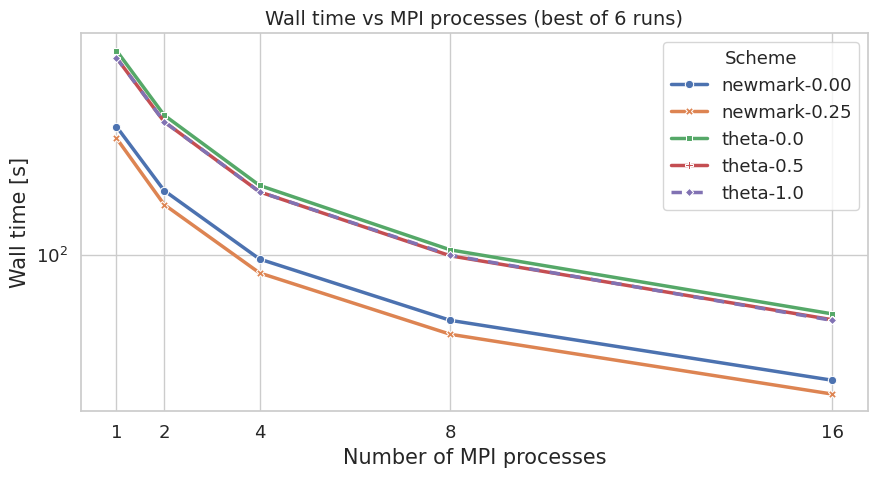

In [21]:
# --- Wall time (log scale) ---
plt.figure(figsize=(9, 5))

# Make all schemes solid, except theta-1.0 dashed
dash_map = {s: "" for s in dfm_agg["scheme"].unique()}
dash_map["theta-1.0"] = (3, 3)

ax = sns.lineplot(
    data=dfm_agg, x='nprocs', y='seconds',
    hue='scheme', style='scheme', markers=True, dashes=dash_map, linewidth=2.5,
    errorbar=None,
)
ax.set_title('Wall time vs MPI processes (best of 6 runs)')
ax.set_xlabel('Number of MPI processes')
ax.set_ylabel('Wall time [s]')
ax.set_yscale('log')
ax.set_xticks(sorted(dfm_agg['nprocs'].unique()))
ax.legend(title='Scheme')
plt.tight_layout()

### 3.2 Speedup and efficiency

**Speedup** is defined as $S(p) = T(1)/T(p)$ and **efficiency** as $E(p) = S(p)/p$, where $T(p)$ is the best wall time across all repeats and nodes for $p$ processes.

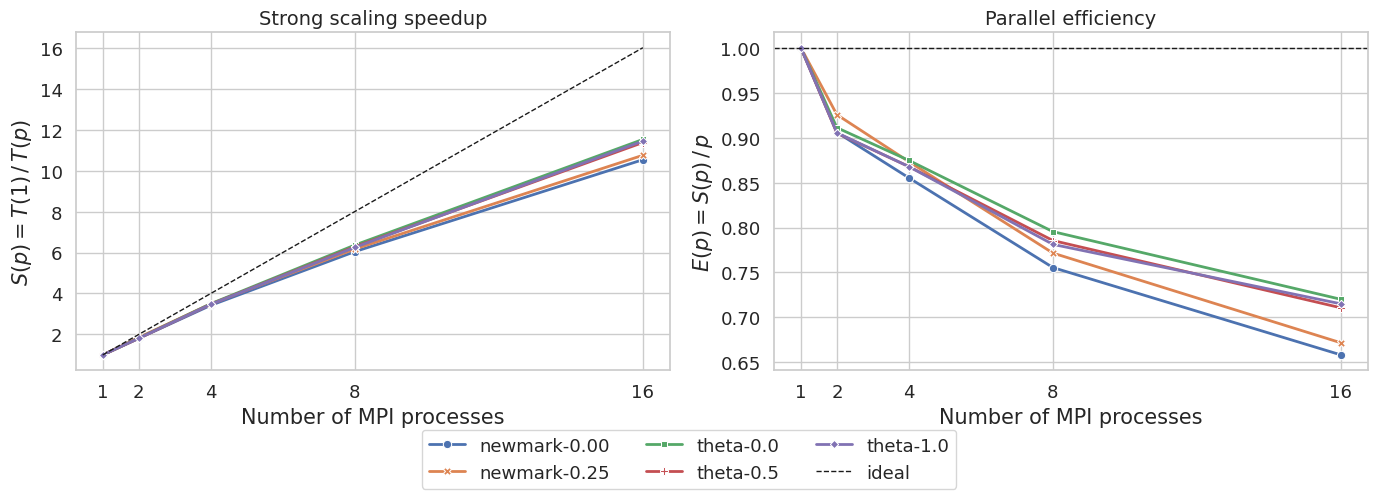

In [22]:
# --- Speedup & Efficiency (side by side) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.lineplot(
    data=dfm_agg, x='nprocs', y='speedup',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[0], errorbar=None,
)
p_max = dfm_agg['nprocs'].max()
axes[0].plot([1, p_max], [1, p_max], color='k', linewidth=1, linestyle='--', label='ideal')
axes[0].set_title('Strong scaling speedup')
axes[0].set_xlabel('Number of MPI processes')
axes[0].set_ylabel(r'$S(p) = T(1)\,/\,T(p)$')

sns.lineplot(
    data=dfm_agg, x='nprocs', y='efficiency',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[1], errorbar=None,
)
axes[1].axhline(1.0, color='k', linewidth=1, linestyle='--', label='ideal')
axes[1].set_title('Parallel efficiency')
axes[1].set_xlabel('Number of MPI processes')
axes[1].set_ylabel(r'$E(p) = S(p)\,/\,p$')
axes[1].set_xticks(sorted(dfm_agg['nprocs'].unique()))
# axes[1].set_ylim(0, max(1.05, float(dfm_agg['efficiency'].max()) * 1.05))

# Single shared legend
handles, labels = axes[0].get_legend_handles_labels()
for ax in axes:
    ax.set_xticks(sorted(dfm_agg['nprocs'].unique()))
    if ax.get_legend() is not None:
        ax.get_legend().remove()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=True, bbox_to_anchor=(0.5, -0.02))
fig.tight_layout(rect=[0, 0.08, 1, 1])

### 3.3 Combined overview

maybe better for the report.

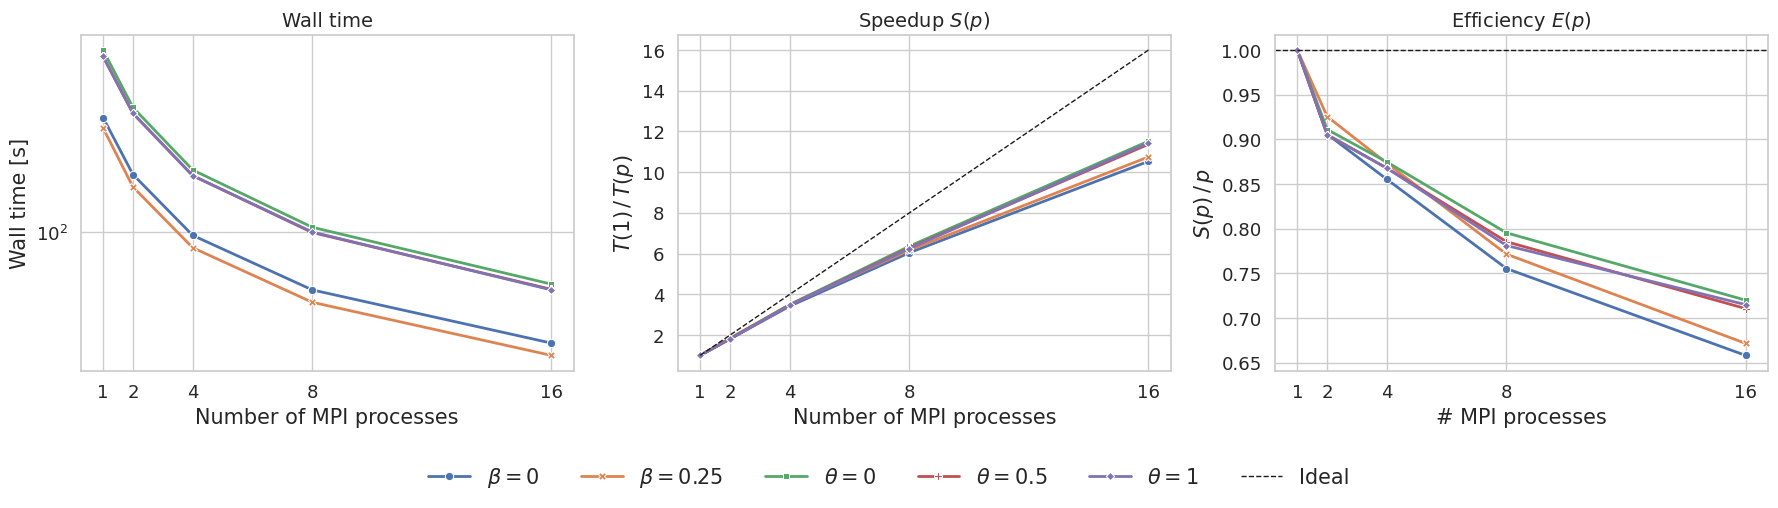

Saved to ../report/images/scalability_strong_scaling.png


In [23]:
# --- Save combined 3-panel plot for the report ---
FIG_DIR = Path("../report/images")
FIG_DIR.mkdir(parents=True, exist_ok=True)

SCHEME_LABELS = {
    "theta-0.0":    r"$\theta=0$",
    "theta-0.5":    r"$\theta=0.5$",
    "theta-1.0":    r"$\theta=1$",
    "newmark-0.00": r"$\beta=0$",
    "newmark-0.25": r"$\beta=0.25$",
}

# Rename schemes for nicer labels
dfm_plot = dfm_agg.copy()
dfm_plot['Scheme'] = dfm_plot['scheme'].map(SCHEME_LABELS)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Wall time
sns.lineplot(
    data=dfm_plot, x='nprocs', y='seconds',
    hue='Scheme', style='Scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[0], errorbar=None,
)
axes[0].set_title('Wall time')
axes[0].set_xlabel('Number of MPI processes')
axes[0].set_ylabel('Wall time [s]')
axes[0].set_yscale('log')
axes[0].set_xticks(sorted(dfm_plot['nprocs'].unique()))

# 2. Speedup
sns.lineplot(
    data=dfm_plot, x='nprocs', y='speedup',
    hue='Scheme', style='Scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[1], errorbar=None,
)
p_max = int(dfm_plot['nprocs'].max())
axes[1].plot([1, p_max], [1, p_max], color='k', linewidth=1, linestyle='--', label='Ideal')
axes[1].set_title(r'Speedup $S(p)$')
axes[1].set_xlabel('Number of MPI processes')
axes[1].set_ylabel(r'$T(1)\,/\,T(p)$')
axes[1].set_xticks(sorted(dfm_plot['nprocs'].unique()))

# 3. Efficiency
sns.lineplot(
    data=dfm_plot, x='nprocs', y='efficiency',
    hue='Scheme', style='Scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[2], errorbar=None,
)
axes[2].axhline(1.0, color='k', linewidth=1, linestyle='--', label='Ideal')
axes[2].set_title(r'Efficiency $E(p)$')
axes[2].set_xlabel('# MPI processes')
axes[2].set_ylabel(r'$S(p)\,/\,p$')
axes[2].set_xticks(sorted(dfm_plot['nprocs'].unique()))

handles, labels = axes[1].get_legend_handles_labels()
for ax in axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()
fig.legend(handles, labels, loc='lower center', ncol=6, 
           fontsize=FONT_SIZE_LEGEND+2, frameon=False, bbox_to_anchor=(0.5, -0.04))
fig.tight_layout(rect=[0, 0.08, 1, 1])
fig.savefig(FIG_DIR / "scalability_strong_scaling.png", bbox_inches="tight", dpi=150)
plt.show()
print(f"Saved to {FIG_DIR / 'scalability_strong_scaling.png'}")

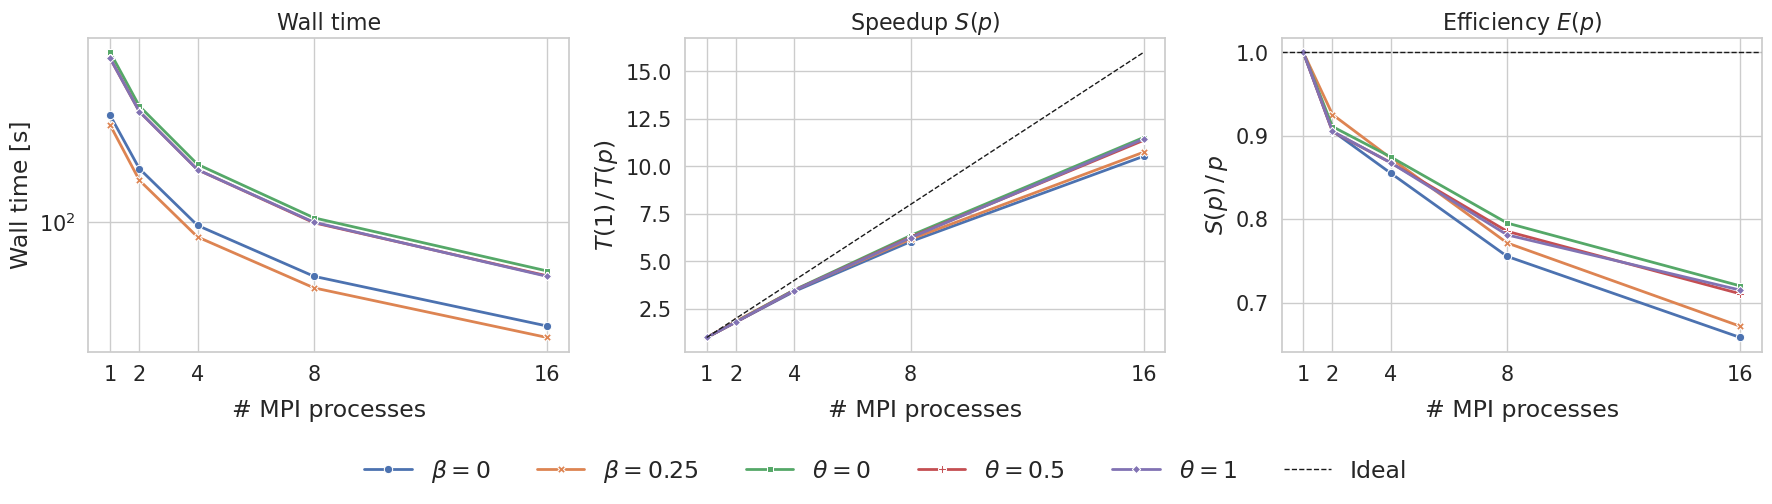

Saved to ../presentation/images/scalability_strong_scaling.png


In [24]:

plt.rcParams.update({
    "font.size":          FONT_SIZE_BASE+2,
    "axes.titlesize":     FONT_SIZE_TITLE+2,
    "axes.labelsize":     FONT_SIZE_LABEL+2,
    "legend.fontsize":    FONT_SIZE_LEGEND+2,
    "xtick.labelsize":    FONT_SIZE_TICK+2,
    "ytick.labelsize":    FONT_SIZE_TICK+2,
    "legend.title_fontsize": FONT_SIZE_LEGEND+4,
})

# --- Save combined 3-panel plot for the report ---
FIG_DIR = Path("../presentation/images")
FIG_DIR.mkdir(parents=True, exist_ok=True)

SCHEME_LABELS = {
    "theta-0.0":    r"$\theta=0$",
    "theta-0.5":    r"$\theta=0.5$",
    "theta-1.0":    r"$\theta=1$",
    "newmark-0.00": r"$\beta=0$",
    "newmark-0.25": r"$\beta=0.25$",
}

# Rename schemes for nicer labels
dfm_plot = dfm_agg.copy()
dfm_plot['Scheme'] = dfm_plot['scheme'].map(SCHEME_LABELS)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Wall time
sns.lineplot(
    data=dfm_plot, x='nprocs', y='seconds',
    hue='Scheme', style='Scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[0], errorbar=None,
)
axes[0].set_title('Wall time')
axes[0].set_xlabel('# MPI processes', labelpad=10)
axes[0].set_ylabel('Wall time [s]')
axes[0].set_yscale('log')
axes[0].set_xticks(sorted(dfm_plot['nprocs'].unique()))

# 2. Speedup
sns.lineplot(
    data=dfm_plot, x='nprocs', y='speedup',
    hue='Scheme', style='Scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[1], errorbar=None,
)
p_max = int(dfm_plot['nprocs'].max())
axes[1].plot([1, p_max], [1, p_max], color='k', linewidth=1, linestyle='--', label='Ideal')
axes[1].set_title(r'Speedup $S(p)$')
axes[1].set_xlabel('# MPI processes', labelpad=10)
axes[1].set_ylabel(r'$T(1)\,/\,T(p)$')
axes[1].set_xticks(sorted(dfm_plot['nprocs'].unique()))

# 3. Efficiency
sns.lineplot(
    data=dfm_plot, x='nprocs', y='efficiency',
    hue='Scheme', style='Scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[2], errorbar=None,
)
axes[2].axhline(1.0, color='k', linewidth=1, linestyle='--', label='Ideal')
axes[2].set_title(r'Efficiency $E(p)$')
axes[2].set_xlabel('# MPI processes',labelpad=10)
axes[2].set_ylabel(r'$S(p)\,/\,p$')
axes[2].set_xticks(sorted(dfm_plot['nprocs'].unique()))

handles, labels = axes[1].get_legend_handles_labels()
for ax in axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()
fig.legend(handles, labels, loc='lower center', ncol=6, 
           fontsize=FONT_SIZE_LEGEND+4, frameon=False, bbox_to_anchor=(0.5, -0.04))
fig.tight_layout(rect=[0, 0.08, 1, 1])
fig.savefig(FIG_DIR / "scalability_strong_scaling.png", bbox_inches="tight", dpi=150)
plt.show()
print(f"Saved to {FIG_DIR / 'scalability_strong_scaling.png'}")

## 4. Conclusions

The solver achieves **good strong scaling** up to 16 cores, for all schemes, for the chosen number of elements.

Newmark reaches lower efficiency due to the lower computational borden needed. It has less computation to solve at each iteration so the portion of parallel work is lower 